## **kmeans**

se intenta hacer kmeans con los datos, falla épicamente

Para correr, subir a la carpeta de Notebooks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import scipy.signal as signal

import sys
sys.path.append('../Librerias')
import dataset as ds

sns.set_style("darkgrid")

In [2]:
# Load data

fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
fname = "datosconsu_021023_bajos.mat"
cutoff = [8/1000, 12/1000]

set =  ds.MatFileToDataFrame(fpath, fname)
df = set.get_dataframe(cutoff)
df.tail()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
599995,5.210999,-0.843661,0.000048,0.000048-0.002326j
599996,5.063692,-0.990968,0.000004,0.000004-0.004341j
599997,5.012726,-1.041933,-0.000039,-0.000039+0.001782j
599998,4.868050,-1.186610,-0.000079,-0.000079-0.000980j
599999,4.806563,-1.248097,-0.000116,-0.000116+0.020513j


In [3]:
#df = pd.DataFrame(mat['data'], columns = ['amp'])
df.rename(columns={'Original Signal': 'amplitude', 'Signal - Mean': 'amp_mean', 'Filtered Signal': 'filtered', 'Hilbert Transform': 'hilbert'}, inplace=True)
df.head()
df['dif'] = df.amp_mean.diff()
df.tail()

,amplitude,amp_mean,filtered,hilbert,dif
599995,5.210999,-0.843661,0.000048,0.000048-0.002326j,-0.112124
599996,5.063692,-0.990968,0.000004,0.000004-0.004341j,-0.147307
599997,5.012726,-1.041933,-0.000039,-0.000039+0.001782j,-0.050966
599998,4.868050,-1.186610,-0.000079,-0.000079-0.000980j,-0.144676
599999,4.806563,-1.248097,-0.000116,-0.000116+0.020513j,-0.061487


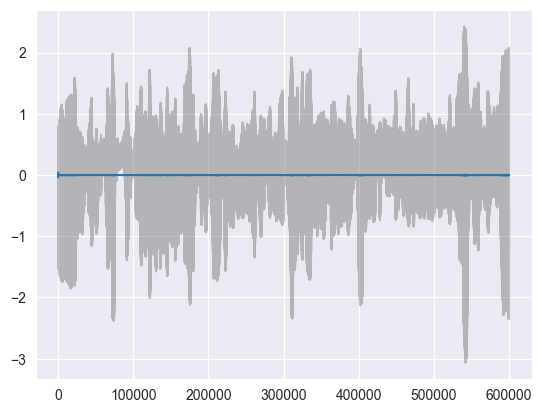

In [4]:
plt.plot(df.amp_mean, color = 'grey', alpha = 0.5)
plt.plot(df.filtered)
plt.show()

In [5]:
#deprecated

df_window = np.array_split(df.filtered, 50)
df_window =np.array(df_window)
df_window.shape

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


(50, 12000)

### **fase instantanea**
Se calcula la fase instantanea de toda la señal, dado que el cambio de fase es una serie de tiempo, por lo que no es necesario calcularlo para cada ventana.

In [6]:
# filtro de hilbert
#s_filt =  signal.hilbert(df_filtered)
amp_envelope_filt = np.abs(df.hilbert)
inst_phase_filt =  np.unwrap(np.angle(df.hilbert))
inst_freq_filt = (np.diff(inst_phase_filt)/(2.0*np.pi) * 1000)
diff_phase =  np.diff(inst_phase_filt)
diff_phase = np.insert(diff_phase, 0, 0) #agrego un cero en el primer coeficiente

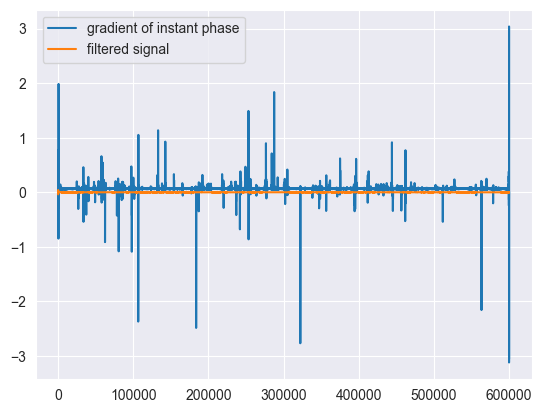

In [7]:
plt.plot(np.diff(inst_phase_filt), label = 'gradient of instant phase')
plt.plot(df.filtered, label = 'filtered signal')
plt.legend()
plt.show()

Se separa el array en 100 arreglos de 6000 muestras cada uno para hacer un dataset con los elementops y hacer clusterings

In [8]:
window_phase = np.array_split(diff_phase, 100)
window_phase =np.array(window_phase)
window_phase.shape

(100, 6000)

In [9]:
# son 100 ventanas (columnas) con 6.000 datos (filas)
df_phase = pd.DataFrame(window_phase)#.transpose()
df_phase.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.000000,0.774918,0.106670,0.299803,0.101627,0.176211,0.093970,0.123208,0.087158,0.094721,...,0.068039,0.071919,0.068885,0.072085,0.069658,0.072093,0.070333,0.071938,0.070889,0.071622
1,0.071308,0.071153,0.071580,0.070545,0.071696,0.069816,0.071656,0.068988,0.071467,0.068087,...,0.067234,0.068257,0.067133,0.067792,0.066983,0.067273,0.066786,0.066708,0.066543,0.066107
2,0.066257,0.065479,0.065931,0.064835,0.065570,0.064183,0.065179,0.063532,0.064762,0.062890,...,0.068746,0.070008,0.069139,0.070173,0.069473,0.070254,0.069739,0.070248,0.069930,0.070155
3,0.070041,0.069977,0.070069,0.069719,0.070014,0.069387,0.069876,0.068988,0.069660,0.068533,...,0.066136,0.067000,0.066352,0.066941,0.066535,0.066835,0.066680,0.066687,0.066785,0.066497
4,0.066847,0.066271,0.066865,0.066013,0.066838,0.065727,0.066767,0.065419,0.066654,0.065095,...,0.067101,0.069818,0.067883,0.070611,0.068682,0.071366,0.069484,0.072066,0.070273,0.072691


### **clustering**

Primero intentamos con kmeans y se normalizan los datos. Se prueban 3 tipos: Standar, MinMax y Max. Se queda con Standar porque los tres tienen los mismos resultados.

#### **Static clustering con kmeans**

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

norm =  StandardScaler()
kmeans =  KMeans(n_clusters=5, random_state=0)

In [11]:
#scaled = norm.fit_transform(df_phase)
#kmeans.fit(scaled)
kmeans.fit(df_phase)
labels = kmeans.predict(df_phase)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
labels = pd.DataFrame(labels, columns = ['labels'])
labels.value_counts()

labels
0         96
1          1
2          1
3          1
4          1
Name: count, dtype: int64

Agrego los labels al dataset, de manera de tener identificada las ventanas con su label respectivo. Luego elijo el cluster con menor cantidad de datos para analizar si en estas ventanas se encuentra el defecto o no.

In [13]:
df_phase['labels'] = labels
df_phase.head()

df_phase0 = df_phase[df_phase['labels'] == 0]
df_phase0.shape

(96, 6001)

In [14]:
df_phase0.index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
       93, 94, 95, 96, 97, 98],
      dtype='int64')

##### **analisis de clusters**

Se toman los indices de estas ventanas y se buscan en el array con la señal original para ver espectograma u otras cosas.
Notar que se encontraron 4 clusters y solo 1 tenía más de 1 elemento y este es el que se esta inspeccionando.

In [15]:
df_interested = [df_phase0.index]
df_interested

[Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
        75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
        93, 94, 95, 96, 97, 98],
       dtype='int64')]

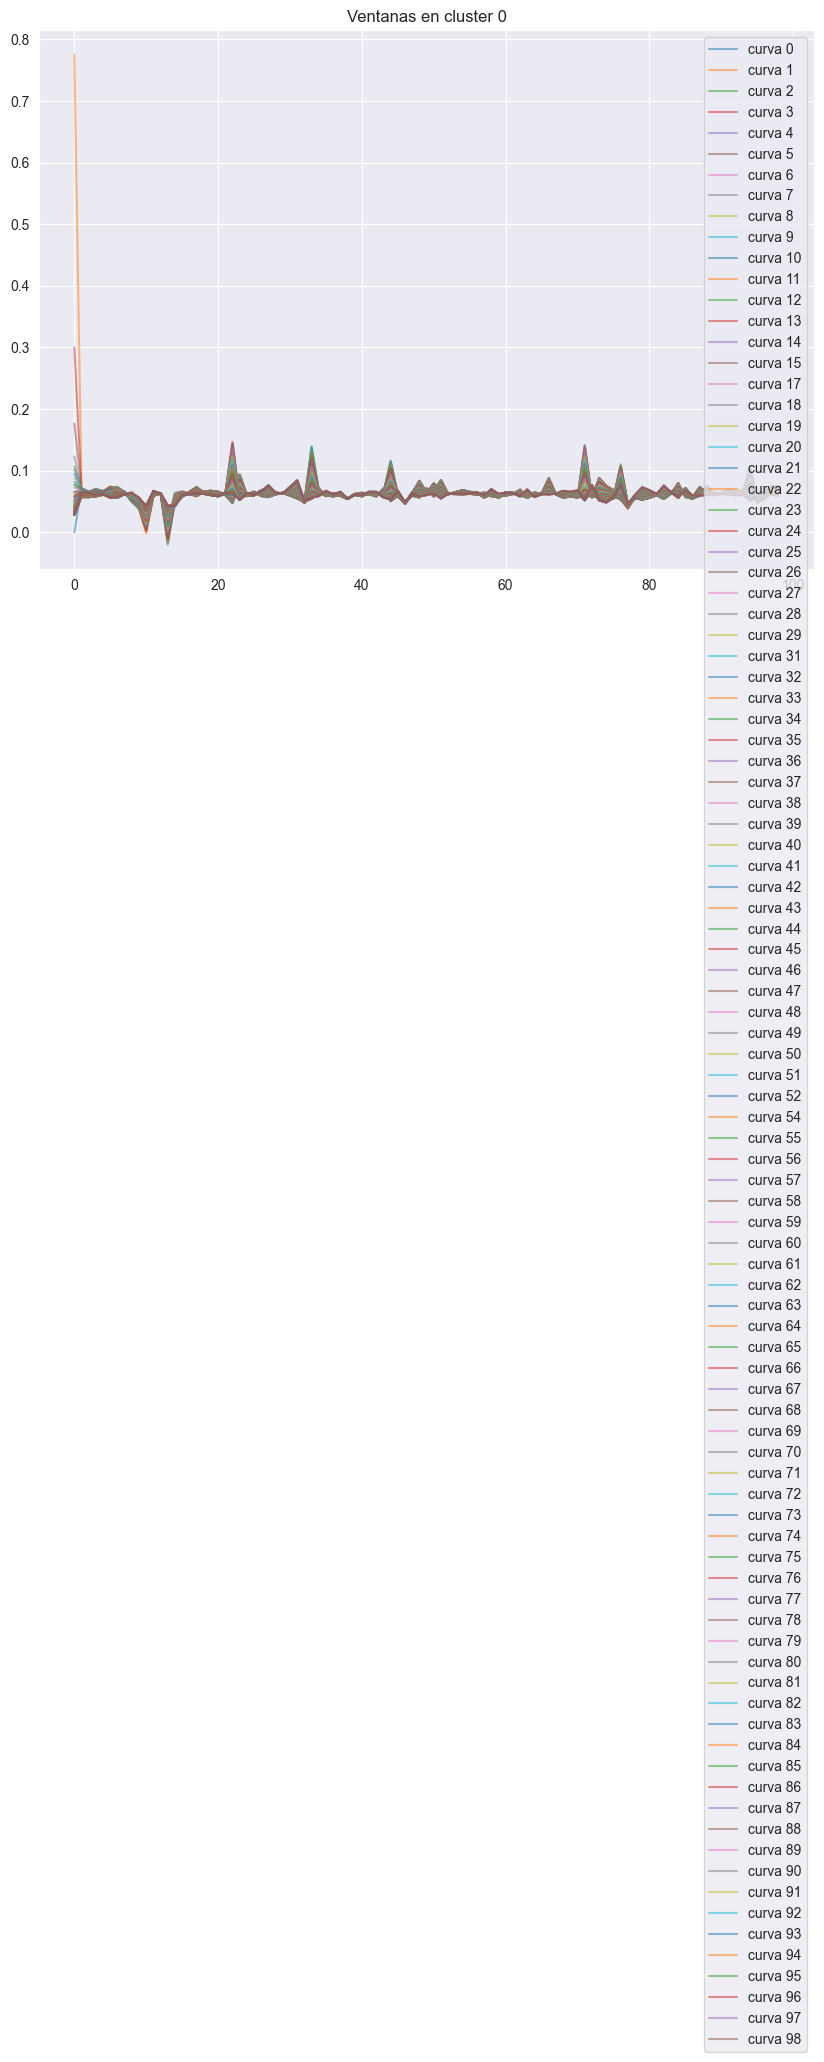

In [16]:
plt.figure(figsize = (10,7))

for elem in df_phase0.index:
    plt.plot(df_phase0[elem], label = f'curva {elem}', alpha = 0.5)

plt.title('Ventanas en cluster 0')
plt.legend()
plt.show()


A simple vista se ve que hay dos curvas muy parecidas, que serían la curva 8 y la 13, mientras que el resto se parecen entre ellas.

**Espectogramas**

In [18]:
X = np.zeros([96,24,146])
f_ = []
t_ =[]

for i, window in enumerate(np.asanyarray(df_phase0)):
    f,t, Sxx = signal.spectrogram(window, fs = 1000, nperseg = 46)
    X[i] = Sxx
    t_.append(t)
    f_.append(f)



IndexError: list index out of range

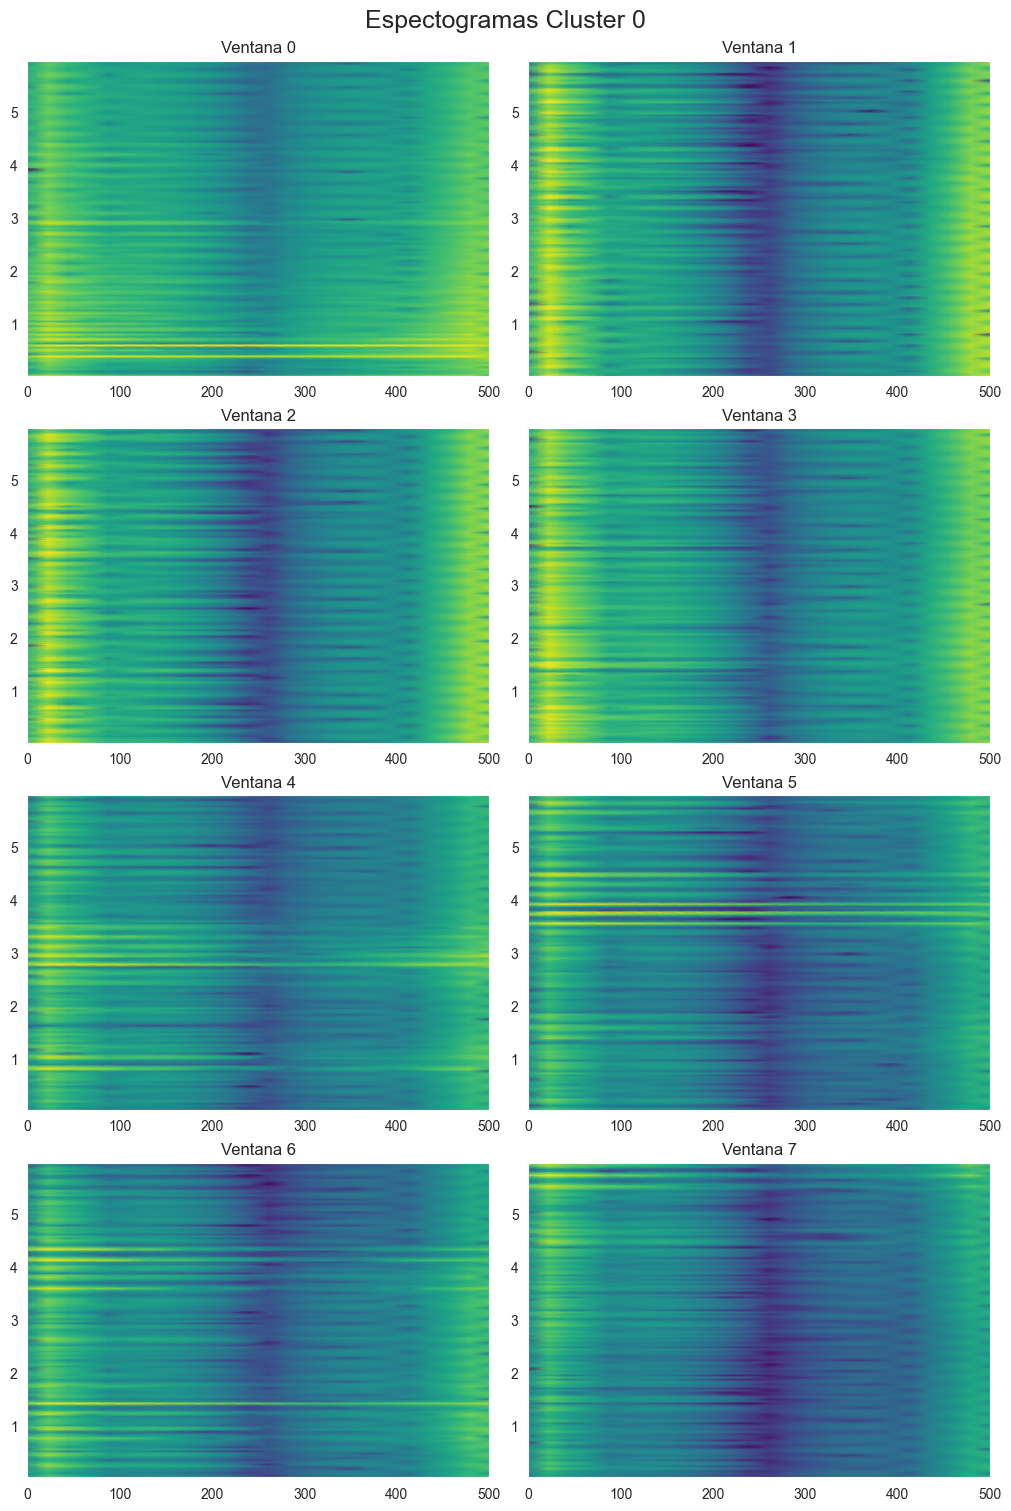

In [19]:
#plt.figure(figsize = (10,10))

figure, axis = plt.subplots(4, 2, figsize = (10,15), constrained_layout=True)
figure.suptitle('Espectogramas Cluster 0', fontsize = 18)
x = [0,1,0,1,0,1,0,1]
y = [0,0,1,1,2,2,3,3]
for i,elem in enumerate(X):
    axis[y[i],x[i]].pcolormesh(f_[i],t_[i],elem.T, shading='gouraud', cmap = 'viridis', norm = 'log')
    #plt.xlim([0,150])
    #plt.ylabel('Segmento Temporal [n]')
    #plt.xlabel('Frecuencia [Hz]')
    axis[y[i]][x[i]].set_title(f'Ventana {df_phase0.index[i]}')
plt.show()

Especificamente, no se ven mayores diferencias en los espectogramas de las distintas ventanas en el cluster, por lo que se va a tomar una ventana anterior y una después para ver si hay alguna diferencia.
Especificamente, de la ventana 50

In [20]:
indices = [61, 62, 63]
df_50 = np.asanyarray(df_phase.loc[indices])

X50 = np.zeros([3,501,6])
f_ = []
t_ =[]

for i,window in enumerate(df_50):
    f,t, Sxx = signal.spectrogram(window, fs = 1000, nperseg = 1000)
    X50[i] = Sxx
    t_.append(t)
    f_.append(f)


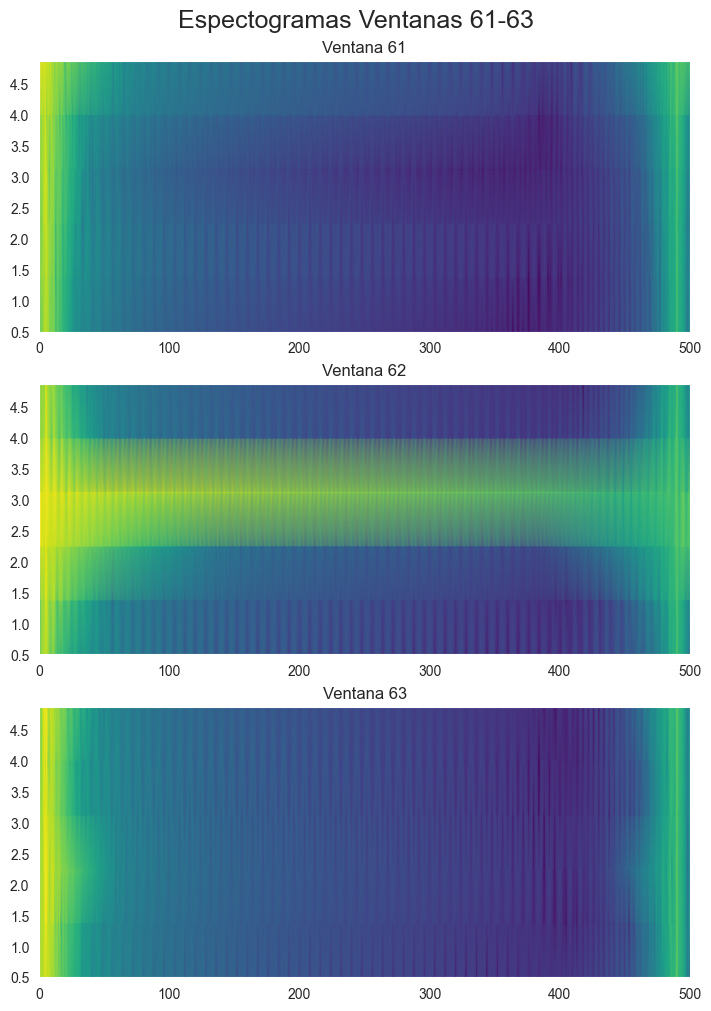

In [21]:
figure, axis = plt.subplots(3, 1, figsize = (7,10), constrained_layout=True)
figure.suptitle(f'Espectogramas Ventanas {indices[0]}-{indices[-1]}', fontsize = 18)
for i,elem in enumerate(X50):
    axis[i].pcolormesh(f_[i],t_[i],elem.T, shading='gouraud', cmap = 'viridis', norm = 'log')
    #plt.xlim([0,150])
    #plt.ylabel('Segmento Temporal [n]')
    #plt.xlabel('Frecuencia [Hz]')
    axis[i].set_title(f'Ventana {indices[i]}')
plt.show()

Se hace una resta de los espectogramas, para ver si existe alguna diferencia sustancial entre las frecuencias encontradas

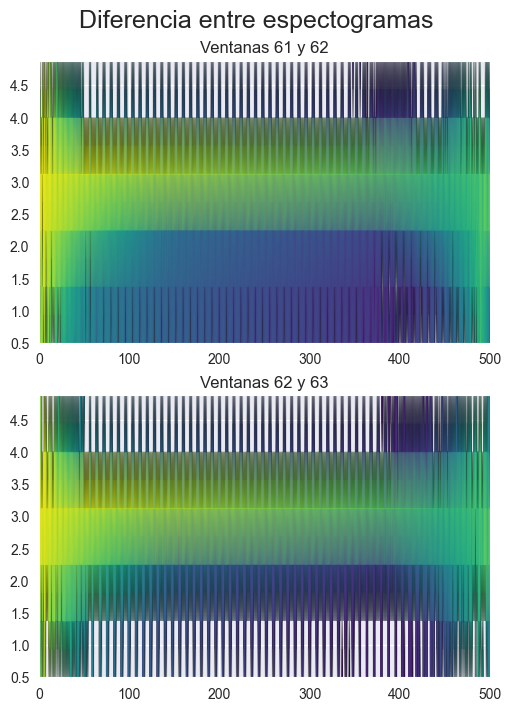

In [22]:
X60_dif =  [X50[1]-X50[0], X50[1]-X50[2]]

figure, axis = plt.subplots(2, 1, figsize = (5,7), constrained_layout=True)
figure.suptitle(f'Diferencia entre espectogramas', fontsize = 18)
for i,elem in enumerate(X60_dif):
    axis[i].pcolormesh(f_[i],t_[i],elem.T, shading='gouraud', cmap = 'viridis', norm = 'log')
    axis[i].set_title(f'Ventanas {indices[i]} y {indices[i+1]}')
plt.show()